In [1]:
import pandas as pd


df = pd.read_json("ParlaSpeech-HR.v1.0.jsonl", orient="records", lines=True)
df["audio_length"] = df.end-df.start
df = df[df.audio_length >= 8]
df = pd.concat([df, df.speaker_info.apply(pd.Series)], axis=1)
df.head(3)

,path,orig_file,start,end,words,word_start_times,norm_words,norm_words_start_times,utterance_id_start,utterance_id_end,...,norm_words_edited,audio_length,Speaker_role,Speaker_type,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth
0,rFVDr4ghXlQ_10620.07-10632.05.wav,"20 2 2020 - 1. dio, 16. sjednica, 9. saziv [rF...",10620.07,10632.05,"[interpretacija,, inzistiranje, na, tim, dezin...","[0, 1.0, 1.83, 1.96, 2.22, 3.79, 4.01, 4.43, 5...","[interpretacija, inzistiranje, na, tim, dezinf...","[0, 1.0, 1.83, 1.96, 2.22, 3.79, 4.01, 4.43, 5...",ParlaMint-HR_S16.u4568,ParlaMint-HR_S16.u4568,...,NaN,11.98,Regular,MP,HDZ,Klub Hrvatske demokratske zajednice,Coalition,"Tuđman, Miroslav",M,1946
1,Ki_SnDM_EkQ_2917.58-2937.5.wav,"18 10 2018 - 9. sjednica, 9. saziv [Ki_SnDM_Ek...",2917.58,2937.50,"[izraelska, tvrtka, prodaje, avione, Hrvatskoj...","[0, 0.65, 1.04, 1.54, 1.92, 2.51, 3.11, 3.5700...","[izraelska, tvrtka, prodaje, avione, hrvatskoj...","[0, 0.65, 1.04, 1.54, 1.92, 2.51, 3.11, 3.5700...",ParlaMint-HR_S09.u4267,ParlaMint-HR_S09.u4267,...,NaN,19.92,Regular,MP,"Živi zid, SNAGA",Klub Živog zida i SNAGA-e,Opposition,"Bunjac, Branimir",M,1972
2,XguZsDKdRh4_13797.59-13811.74.wav,"20 1 2017 - 3. sjednica, 9. saziv [XguZsDKdRh4...",13797.59,13811.74,"[jučer, trećem,, sutra, ili, prekosutra, četvr...","[0, 0.43, 1.0, 1.4, 1.52, 2.01, 2.55, 3.12, 3....","[jučer, trećem, sutra, ili, prekosutra, četvrt...","[0, 0.43, 1.0, 1.4, 1.52, 2.01, 2.55, 3.12, 3....",ParlaMint-HR_S03.u9702,ParlaMint-HR_S03.u9702,...,NaN,14.15,Regular,MP,HDZ,Klub Hrvatske demokratske zajednice,Coalition,"Bačić, Branko",M,1959


In [2]:

from datetime import datetime
def get_date_from_filename(s: str)->datetime:
    from parse import compile
    pattern = "{day:d} {month:d} {year:d} {rest}"

    p = compile(pattern)
    results = p.search(s)

    if not results:
        return None
    return datetime(results["year"], results["month"], results["day"])

df["recording_datetime"] = df.orig_file.apply(get_date_from_filename)


In [3]:
def get_speaker_age_at_recording(row):
    try:
        return row["recording_datetime"].year - int(row["Speaker_birth"])
    except ValueError:
        return None

df["Speaker_age_at_recording"] = df.apply(get_speaker_age_at_recording, axis=1)

In [4]:
df = df[~df.Speaker_age_at_recording.isna()]

In [5]:
gb = df.groupby("Speaker_name").agg({
    "path": "count",
    "Speaker_age_at_recording": "median",
    "Speaker_gender": lambda i: i.iloc[0],
}).rename(columns={"path": "Count"}).sort_values(by="Count", ascending=False)
gb =  gb.loc[(gb.Count > 100) & (gb.Count < 3000)]


In [7]:
gb.shape

(128, 3)

In [8]:
{f"{G} median age": gb[gb.Speaker_gender==G].Speaker_age_at_recording.median() for G in "MF"}

# gb[gb.Speaker_gender=="F"].Speaker_age_at_recording.median(), gb[gb.Speaker_gender=="M"].Speaker_age_at_recording.median(), 

{'M median age': 49.0, 'F median age': 46.0}

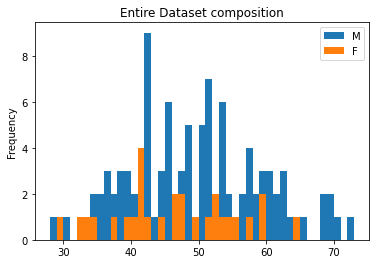

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for gender in "MF":
    gb[gb.Speaker_gender == gender].Speaker_age_at_recording.plot.hist(
        ax=ax,
        label=gender,
        bins=range(
            gb.Speaker_age_at_recording.astype(int).min(),
            gb.Speaker_age_at_recording.astype(int).max(),
        ),
    )
plt.legend()
plt.title("Entire Dataset composition")
plt.show()


Border for men shall be 49, for women 46

In [9]:
age_category = []
for speaker, row in gb.iterrows():
    if row["Speaker_gender"] == "M":
        if row["Speaker_age_at_recording"] >49:
            age_category.append("old")
        else:
            age_category.append("young")
    else:
        if row["Speaker_age_at_recording"] > 46:
            age_category.append("old")
        else:
            age_category.append("young")
gb["Speaker_age_group"] = age_category
gb.head()

,Count,Speaker_age_at_recording,Speaker_gender,Speaker_age_group
Speaker_name,,,,
"Đujić, Saša",2980,38.0,M,young
"Bauk, Arsen",2914,45.0,M,young
"Babić, Ante",2727,52.0,M,old
"Jovanović, Željko",2718,53.0,M,old
"Lenart, Željko",2624,50.0,M,old


In [19]:
gb.shape

(100, 4)

In [10]:
gb = gb[gb.Speaker_gender == "M"]

  0%|          | 0/200 [00:00<?, ?it/s]

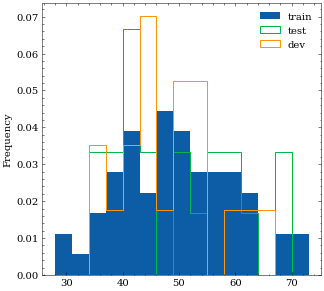

In [49]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
r = range(gb.Speaker_age_at_recording.astype(int).min(), gb.Speaker_age_at_recording.astype(int).max(), 3)
plt.style.use(["science", "no-latex"])
fig, ax = plt.subplots(figsize=(5,5))


def calc_similarity(v1, v2, v3):
    cos_sim1 = np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    cos_sim2 = np.dot(v1, v3)/(np.linalg.norm(v1)*np.linalg.norm(v3))

    return 0.5 * cos_sim1 + 0.5 * cos_sim2

best_i, best_j = 0,0
best_sim = 0

from tqdm.auto import tqdm

for i in tqdm(range(200)):
    for j in range(200):
        train, devtest = train_test_split(gb, train_size=0.6, random_state=i, stratify=gb.Speaker_age_group)
        dev, test = train_test_split(devtest, train_size=0.5, random_state=j, stratify=devtest.Speaker_age_group)
        train_vector = np.histogram(train.Speaker_age_at_recording, bins=r)[0]
        dev_vector = np.histogram(dev.Speaker_age_at_recording, bins=r)[0]
        test_vector = np.histogram(test.Speaker_age_at_recording, bins=r)[0]

        sim = calc_similarity(train_vector, dev_vector, test_vector)
        if sim > best_sim:
            best_sim = sim
            best_i, best_j = i, j


train, devtest = train_test_split(gb, train_size=0.6, random_state=i, stratify=gb.Speaker_age_group)
dev, test = train_test_split(devtest, train_size=0.5, random_state=j, stratify=devtest.Speaker_age_group)

train.Speaker_age_at_recording.plot.hist(ax=ax, label="train", density=True, bins=r)
test.Speaker_age_at_recording.plot.hist(ax=ax, label="test", density=True, bins=r, histtype="step")
dev.Speaker_age_at_recording.plot.hist(ax=ax, label="dev", density=True, bins=r, histtype="step")
plt.legend()
plt.show()



In [50]:
train.shape

(60, 4)

In [51]:
train_data = []
train = train.index.tolist()
test = test.index.tolist()
dev = dev.index.tolist()

for speaker, row in gb.loc[train, :].iterrows():
    clips = df[df.Speaker_name == speaker].path.sample(20).values.tolist()
    for clip in clips:
        train_data.append({
            "Speaker_name": speaker,
            **row,
            "path": clip
        })

train_df = pd.DataFrame(data=train_data)

test_data = []
for speaker, row in gb.loc[test, :].iterrows():
    clips = df[df.Speaker_name == speaker].path.sample(50).values.tolist()
    for clip in clips:
        test_data.append({
            "Speaker_name": speaker,
            **row,
            "path": clip
        })

test_df = pd.DataFrame(data=test_data)

dev_data = []
for speaker, row in gb.loc[dev, :].iterrows():
    clips = df[df.Speaker_name == speaker].path.sample(50).values.tolist()
    for clip in clips:
        dev_data.append({
            "Speaker_name": speaker,
            **row,
            "path": clip
        })

dev_df = pd.DataFrame(data=dev_data)


Checking hyigienicity of the splits:

In [52]:
set(train_df.Speaker_name.tolist()).intersection(test_df.Speaker_name.tolist())

set()

In [53]:
set(dev_df.Speaker_name.tolist()).intersection(test_df.Speaker_name.tolist())

set()

In [56]:
files_to_move = test_df.path.tolist() + train_df.path.tolist()

with open("006_files_to_move.txt", "w") as f:
    for file in files_to_move:
        f.write(file+"\n")

test_df["path"] = test_df.path.apply(lambda s: "data_age/seg."+s)
train_df["path"] = train_df.path.apply(lambda s: "data_age/seg."+s)
dev_df["path"] = dev_df.path.apply(lambda s: "data_age/seg."+s)
test_df.to_csv("006_age_test.csv", index=False)
train_df.to_csv("006_age_train.csv", index=False)
dev_df.to_csv("006_age_dev.csv", index=False)